In [123]:
import warnings
warnings.filterwarnings('ignore')

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.signal as sig
import control as con
%pylab inline
from statsmodels.tsa.arima_model import ARIMA


Populating the interactive namespace from numpy and matplotlib


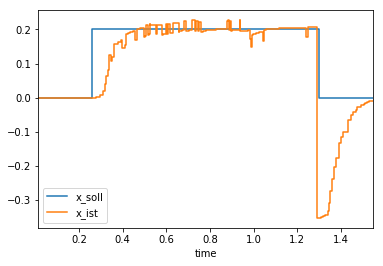

In [125]:
df_soll = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-25-18_control_output.log',
                 header=0,
                 names=['time', 'x_soll'])
df_soll = df_soll.set_index('time')
df_ist = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-25-19_task_vel.log',
                 header=0,
                 names=['time', 'x_ist'])
df_ist = df_ist.set_index('time')
df_ist_soll = pd.concat([df_soll.x_soll, df_ist.x_ist], axis=1).fillna(method='pad')
df_ist_soll = df_ist_soll.fillna(0)
df_ist_soll.plot(style='-', drawstyle="steps")
plt.savefig('real_data_1.png')

In [126]:
df_ist_soll = df_ist_soll[df_ist_soll.x_ist > 0]

In [127]:
T = df_ist_soll.index.tolist()
yout = (5*df_ist_soll['x_ist']).tolist()
xin = (5*df_ist_soll['x_soll']).tolist()

In [128]:
c=-1
for i in range(0,len(xin)):
    if xin[i] == 0.0:
        c = c+1
    else:
        break

In [129]:
xin_old = xin
yout_old = yout
T_old = T

In [130]:
xin = xin[c:]
yout = yout[c:]
T = T[c:]
T=T-T[0]

In [76]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [77]:
%R -i xin
%R -i yout
%R -i T

In [78]:
#%R install.packages("forecast",repos="https://ftp.gwdg.de/pub/misc/cran/",lib="/home/ipa325/R/x86_64-pc-linux-gnu-library/3.4/")

In [79]:
%R require(ggplot2)
%R library(stats)
%R library(sysid,lib.loc="/home/ipa325/R/x86_64-pc-linux-gnu-library/3.4/")
%R library(forecast,lib.loc="/home/ipa325/R/x86_64-pc-linux-gnu-library/3.4/")

array(['forecast', 'sysid', 'ggplot2', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U9')

In [107]:
%R yout<-unlist(yout)                                           #added newly in R version 3.4.2
%R sysar = ar(yout,method="ols",order.max=15)
%R far =fitted.values(sysar)
%R -o far
far_new=np.nan_to_num(far)
%R sysar_new = sysar[2]
%R print(sysar_new)


$ar
, , 1

             [,1]
 [1,]  0.58153966
 [2,] -0.27282690
 [3,]  0.17362020
 [4,] -0.06793235
 [5,]  0.08254997
 [6,]  0.02299239
 [7,]  0.13426351
 [8,]  0.04759521
 [9,] -0.03897547
[10,]  0.05060026
[11,] -0.02752622




In [80]:
def order_ar(ar_order):
    %R -i ar_order
    %R yout<-unlist(yout)                                           #added newly in R version 3.4.2
    %R sysar = ar(yout,method="ols",order.max=ar_order)
    %R far =fitted.values(sysar)
    %R -o far
    far_new=np.nan_to_num(far)
    %R sysar_new = sysar[2]
    %R -o sysar_new
    mse_ar = mean_squared_error(yout, far_new)
    np_ar = len(sysar_new[0])
    %R -i mse_ar
    %R -i np_ar 
    %R N <- length(yout) 
    %R aic_ar <- N*log(mse_ar) + 2*np_ar + N*dim(matrix(yout))[2]*(log(2*pi)+1)
    %R -o aic_ar,mse_ar
    return aic_ar,mse_ar,far_new

In [131]:
def order_ar(ar_order):
    sysar = ARIMA(yout, order=(ar_order, 0, 0))
    far = sysar.fit().fittedvalues
    far[0] = 0
    far_new = far
    mse_ar = mean_squared_error(yout, far_new)
    np_ar = len(sysar.fit().params)
    N = len(yout) 
    aic_ar = N*np.log(mse_ar) + 2*np_ar + N*1*(np.log(2*np.pi)+1)
    return aic_ar,mse_ar,far_new

In [133]:
aic = []
L = []
mse = []
for l in range(1,10):
  aic.append(order_ar(l)[0])
  mse.append(order_ar(l)[1])
  L.append(l)
df = pd.DataFrame(np.column_stack([np.array(L),np.array(aic),np.array(mse)]),columns=['l','aic','mse']) 

In [134]:
w = np.array(df.l[df.mse==df.mse.min()].astype(int))[0]
mse_ar = np.array(df.mse[df.mse==df.mse.min()])[0]
aic_ar = np.array(df.aic[df.mse==df.mse.min()])[0]
far_new = order_ar(w)[2]

In [83]:
from statsmodels.tsa.arima_model import ARIMA

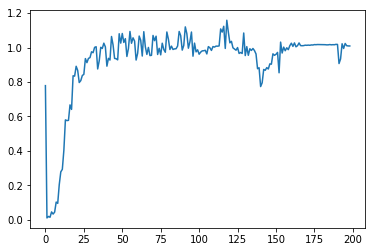

In [112]:
model = ARIMA(yout, order=(15, 0, 0))  
plt.plot(model.fit().fittedvalues)

In [113]:
model.fit().params

array([ 0.77854541,  0.8457008 , -0.20223408,  0.29548738, -0.03818022,
        0.1200849 ,  0.03293983,  0.13096551,  0.0157238 , -0.09894969,
        0.03286677, -0.10505696,  0.04681424,  0.01092658, -0.10610518,
        0.00163179])

In [122]:
%R dim(matrix(yout))[2]

array([1], dtype=int32)

In [121]:
len(yout)

199

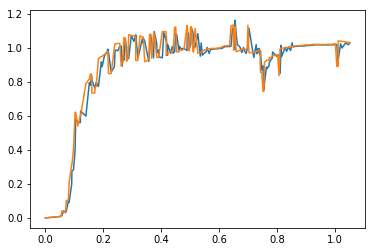

In [101]:
%R sis=ar(yout,method="ols",order.max=15)
%R fs =fitted.values(sis)
%R -o fs
#plt.plot(T,fs)
newfit=model.fit().fittedvalues
newfit[0]=0
plt.plot(T,newfit)
plt.plot(T,yout)

In [95]:
len(model.fit().fittedvalues),len(fs)

(199, 199)

In [16]:
%R -i w
%R sysar = ar(yout,method="ols",order.max=w)
%R print(sysar)


Call:
ar(x = yout, order.max = w, method = "ols")

Coefficients:
      1        2        3        4        5        6        7        8  
 0.6331  -0.2556   0.2197  -0.0696   0.1065   0.0055   0.1446  -0.0143  

Intercept: 0.01851 (0.004488) 

Order selected 8  sigma^2 estimated as  0.003135


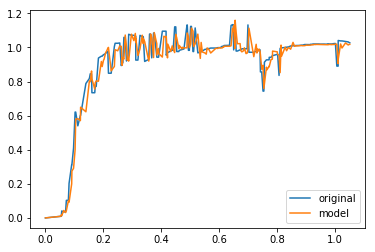

In [136]:
plt.plot(T,yout,label='original')
plt.plot(T,far_new,label='model')
plt.legend()

In [138]:
far_new

array([ 0.        ,  0.00939533,  0.01776692,  0.013268  ,  0.04364241,
        0.03127141,  0.04246801,  0.09971143,  0.09232987,  0.19989853,
        0.27443184,  0.29105412,  0.40001766,  0.57955076,  0.58219882,
        0.57078078,  0.64943594,  0.62274767,  0.80273916,  0.79894052,
        0.86187832,  0.81569454,  0.75624191,  0.7922222 ,  0.80368018,
        0.80200051,  0.91783947,  0.88805002,  0.92540671,  0.93077307,
        0.96973043,  0.98101539,  0.99546656,  1.00028948,  0.86296871,
        0.88861946,  0.98686053,  0.98047328,  1.00889354,  1.00646773,
        0.89489161,  0.93958868,  0.93205545,  1.07294541,  1.00308597,
        0.92546415,  0.94198694,  0.91989876,  1.07793054,  1.04010715,
        1.08240708,  1.03191886,  1.05467557,  0.95271368,  0.99164877,
        1.07203681,  1.022838  ,  1.05129279,  1.0347475 ,  0.92012318,
        0.95778967,  1.07926201,  1.05779675,  0.94074935,  1.08750135,
        1.02257787,  0.95603769,  0.99427548,  0.96364032,  0.94

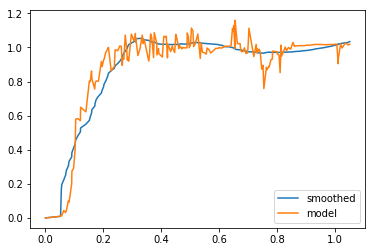

In [147]:
y_ar=far_new.ravel()
y_ar=far_new.ravel()
cou = 0
for i in range(0,len(y_ar)):
    if y_ar[i]<=0.01:
        cou=cou+1
    else:
        break

y_ar_new = y_ar[cou:]
if len(y_ar_new)%2!=0:
    d_ar = sig.savgol_filter(y_ar_new,round(len(y_ar_new)/2)+1,2)
else:
    d_ar = sig.savgol_filter(y_ar_new,round(len(y_ar_new)/2),2)
d_ar_new=np.append(y_ar[0:cou],d_ar)
plt.plot(T,d_ar_new,label='smoothed')
plt.plot(T,far_new,label='model')
plt.legend()

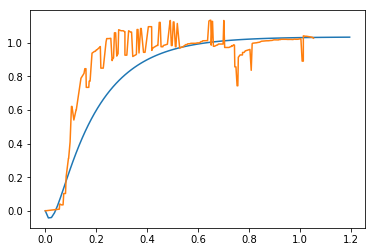

In [146]:
dar=pd.DataFrame(d_ar_new,columns=['vall'])
tim=pd.DataFrame(T,columns=['time'])
dfo=pd.concat([dar,tim],axis=1)
youtdz=d_ar_new
youtd_frame=pd.DataFrame(youtdz,columns=['value'])
yss=youtd_frame.tail(n=1)
yss = pd.Series(yss)
yss = pd.to_numeric(yss)
yss=yss[0]
ystd=yss*(1-np.exp(-1))
yss9=yss*0.9
t90=dfo.time[dfo.index == abs(dfo.vall-yss9).sort_values().index[0]].values[0]
t10 = dfo[dfo.vall>0].values[0][1]
a0 = 1
a1 = dfo.time[dfo.index == abs(dfo.vall-ystd).sort_values().index[0]].values[0]
b0 = yss
tf_1 = con.matlab.tf(b0, [a1, a0])
n_1, d_1 = con.pade(t10, 1)
dela = con.matlab.tf(n_1,d_1)
youto, to = con.matlab.step(tf_1*dela) #,np.linspace(0,max(T))

plt.plot(to,youto)
#plt.plot(T,d_ar_new,label='smoothed')
plt.plot(T,yout,label='model')
#plt.savefig('11.png')

In [20]:
con.matlab.tf2ss(tf_1*dela)

A = [[ -32.68130319 -201.07791994]
 [   1.            0.        ]]

B = [[ 1.]
 [ 0.]]

C = [[  -8.48140456  207.46307108]]

D = [[ 0.]]

In [183]:
d_ar_new

array([ 0.        ,  0.00939533,  0.1662975 ,  0.19500476,  0.22326637,
        0.25108232,  0.27845262,  0.30537727,  0.33185626,  0.3578896 ,
        0.38347729,  0.40861932,  0.4333157 ,  0.45756642,  0.48137149,
        0.50473091,  0.52764467,  0.55011278,  0.57213524,  0.59371204,
        0.61484319,  0.63552868,  0.65576852,  0.67556271,  0.69491125,
        0.71381413,  0.73227135,  0.75028293,  0.76784884,  0.78496911,
        0.80164372,  0.81787268,  0.83365598,  0.84899363,  0.86388563,
        0.87833197,  0.89233266,  0.9058877 ,  0.91899708,  0.93166081,
        0.94387888,  0.9556513 ,  0.96697807,  0.97785918,  0.98829464,
        0.99828445,  1.0078286 ,  1.0169271 ,  1.02557994,  1.03378713,
        1.04154867,  1.04886456,  1.05120364,  1.05248742,  1.05334387,
        1.05240809,  1.05046543,  1.04815524,  1.04460073,  1.04156898,
        1.038577  ,  1.03492479,  1.03198889,  1.03111977,  1.02972734,
        1.02615613,  1.02366359,  1.01991843,  1.02063893,  1.01

In [148]:
youtdz=d_ar_new
youtd_frame=pd.DataFrame(youtdz,columns=['value'])
yss=youtd_frame.tail(n=1)
yss = pd.Series(yss)
yss = pd.to_numeric(yss)
yss=yss[0]

In [198]:
td_frame=pd.DataFrame(T,columns=['time'])
df = pd.concat([td_frame,youtd_frame],axis=1)

#dfs = pd.concat([td_frame,youtd_frame],axis=1)
#df=df[df.value>0.01].reset_index(drop=True)

In [199]:
#adi=df.time[0]
#timey=pd.DataFrame(list(df.time-adi),columns=['timey'])
#df=pd.concat([df,timey],axis=1)


In [200]:
df

,time,value
0,0.000000,0.000000
1,0.052359,0.009395
2,0.055042,0.166297
3,0.056421,0.195005
4,0.063427,0.223266
5,0.069719,0.251082
6,0.072383,0.278453
7,0.079365,0.305377
8,0.081763,0.331856
9,0.090813,0.357890


In [205]:
df.time[df.index==abs(df.value-yss1).sort_values().value_counts().max()-1].values[0],df.time[df.index==abs(df.value-yss1).sort_values().value_counts().max()].values[0]

(0.0, 0.052359104157000014)

In [224]:
yss1=yss*0.1
yss3=yss*0.3
yss6=yss*0.6
yss9=yss*0.9
#t1 = df.time[df.index == abs(df.value-yss1).sort_values().index[0]].values[0]
t1 = df.time[df.index==abs(df.value-yss1).sort_values().value_counts().max()+1].values[0]
#t1 = np.mean([df.time[df.index==abs(df.value-yss1).sort_values().value_counts().max()-1].values[0],df.time[df.index==abs(df.value-yss1).sort_values().value_counts().max()].values[0]])
t3 = df.time[df.index == abs(df.value-yss3).sort_values().index[0]].values[0]
t6 = df.time[df.index == abs(df.value-yss6).sort_values().index[0]].values[0]
t9 = df.time[df.index == abs(df.value-yss9).sort_values().index[0]].values[0]
yss1,t1,t3,t6,t9

(0.10344247445371023,
 0.055042028427000012,
 0.079365015030000041,
 0.159471988678,
 0.26213312149100004)

In [215]:
def fourpoint(z):
    f1_zeta = 0.451465 + 0.066696*z + 0.013639*z**2
    f3_zeta = 0.800879 + 0.194550*z + 0.101784*z**2
    f6_zeta = 1.202664 + 0.288331*z + 0.530572*z**2
    f9_zeta = 1.941112 - 1.237235*z + 3.182373*z**2
    return f1_zeta,f3_zeta,f6_zeta,f9_zeta

In [216]:
beta = (t9 - t6)/(t3 - t1)
zeta_est_beta = -0.460805 + 0.976315*beta - 0.254517*beta**2 + 0.028115*beta**3
f1_zeta,f3_zeta,f6_zeta,f9_zeta = fourpoint(zeta_est_beta)

In [217]:
peak1=youtd_frame.max()
peak1 = peak1[0]
overshoot = (peak1 - yss)/yss
zeta_est_overshoot = numpy.sqrt(numpy.log(overshoot)**2 / (numpy.pi**2 + numpy.log(overshoot)**2))
f1_zeta,f3_zeta,f6_zeta,f9_zeta = fourpoint(zeta_est_overshoot)

In [218]:
def method2(z):
    T_est2 = (t9 - t1) / (f9_zeta - f1_zeta) 
    theta_est2 = t1 - T_est2*f1_zeta
    return T_est2,theta_est2

In [219]:
T_est2,theta_est2 = method2(zeta_est_overshoot)

In [220]:
theta_est2

0.011276242719185259

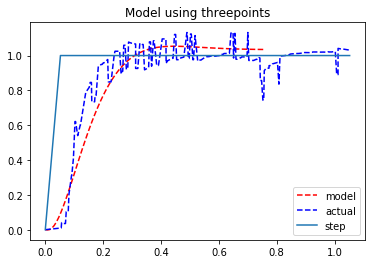

In [221]:
tf_model2 = con.matlab.tf(yss, [T_est2**2,2*zeta_est_overshoot*T_est2, 1])
d_num2, d_den2 = con.pade(theta_est2, 1)
delay2 = con.matlab.tf(d_num2,d_den2)
#yout2,td2 = con.matlab.step(tf_model2,np.linspace(theta_est2,max(T)))
yout2,td2 = con.matlab.step(tf_model2*delay2)
plt.plot(td2,yout2,'--r',label="model")
plt.plot(T,yout,'--b',label='actual')
plt.plot(T,xin,label='step')
plt.title("Model using threepoints")
plt.legend()
plt.savefig('real_data1_ar.png')

In [222]:
delay2


-s + 177.4
----------
s + 177.4

In [ ]:
con.matlab.tf2ss(tf_model2*delay2)

In [ ]:
Y = pd.concat([pd.DataFrame(list(df_ist_soll.index.values),columns=['time']),pd.DataFrame(yout,columns=['y_1'])],axis=1)
X = pd.concat([pd.DataFrame(yout2,columns=['y_12']),pd.DataFrame(td2,columns=['time'])],axis=1)
X1 = list(pd.Series(X.time))
Y1 = list(pd.Series(Y.time))

arr = []
for i in range(0,len(X1)):
    arr.append([])
    for j in range(0,len(Y1)):
        if round(abs(X1[i]))==round(abs(Y1[j])) or (round(X1[i]) == round(Y1[j]+0.5)) or (round(X1[i]+0.5) == round(Y1[j])):
            arr[i].append(Y1[j])

delphi = []
for i in range(0,len(X1)):
    delphi.append(min(abs(X1[i]-arr[i])))
    
    
yoyo=[]
for i in range(0,len(X1)):
    for j in range(0,len(Y1)):
        if abs(X1[i]-Y1[j])==delphi[i]:
            yoyo.append(Y1[j])
            
y12 = []
for i in range(0,len(X1)):
    y12.append(list(Y.y_1[Y.time==yoyo[i]])[0])
    
    
mean_squared_error(y12,yout2)